#### Usage example: Simulation multiverse

This script will create perform the multiverse analysis as shown in Section 4 of the [preprint](https://www.biorxiv.org/content/10.1101/2024.01.21.576546v1).

Brief outline:

* Simulated time series data with two randomly changing connectivity patterns (7.2 second trial lengths)
* Connectivity patterns are predicted from graph measures that are calculated from dFC data on a trial-by-trial basis
* Multiverse options: dFC methods (6), temporal lag (2), graph density (2), graph weights (2), SVC kernel (2) --> 96 universes  

In [1]:
from comet.multiverse import Multiverse

forking_paths = {
                "dfc_method": [
                    {
                        "name": "TSW21",
                        "func": "comet.connectivity.SlidingWindow",
                        "args": {
                            "time_series": "ts_hp",
                            "windowsize": 21,
                            "shape": "gaussian",
                            "std": 7,
                        }
                    },
                    {
                        "name": "SD",
                        "func": "comet.connectivity.SpatialDistance",
                        "args": {
                            "time_series": "ts_hp",
                            "dist": 'euclidean',
                        }
                    },
                    {
                        "name": "MTD7",
                        "func": "comet.connectivity.TemporalDerivatives",
                        "args": {
                            "time_series": "ts_hp",
                            "windowsize": 7,
                        }
                    },
                    {
                        "name": "PSc",
                        "func": "comet.connectivity.PhaseSynchrony",
                        "args": {
                            "time_series": "ts_hp",
                            "method": "crp",
                        }
                    },
                    {
                        "name": "FLS",
                        "func": "comet.connectivity.FlexibleLeastSquares",
                        "args": {
                            "time_series": "ts_hp",
                            "standardizeData": True,
                            "mu": 50,
                            "num_cores": 8,
                        }
                    }],

                "tr": [0.72],           # TR in seconds (not a forking path, but useful as a global parameter)
                "segment_length": [10], # length of each trial segment (in TRs, not a forking path, but useful as a global parameter)

                "delay": [6, 10],               # shift to account for hemodynamic delay (in TR) -> delay*0.72 = 3/5 seconds
                "density": [0.5, 0.25],         # graph density (keep top X% of edges)
                "binarise": [True, False],      # graph binarisation (otherwise weighted)

                "graph_measure": [
                    {
                        "name": "participation",
                        "func": "comet.graph.participation_coef",
                        "args": {
                            "W": "W",
                            "ci": "louvain"
                        }
                    },
                    {
                        "name": "clustering",
                        "func": "comet.graph.clustering_coef",
                        "args": {
                            "W": "W"
                        }
                    },
                    {
                        "name": "efficiency",
                        "func": "comet.graph.efficiency",
                        "args": {
                            "W": "W",
                            "local": True
                        }
                    }
                ],

                "svc_kernel": ["linear", "rbf"] # SVC kernel
}

With the forking paths defined, the analysis pipeline template can be created. Please not that the ```tr``` and ```segment_length``` parameters were also defined in the forking paths to allow for easy changes if necessary.

In [2]:
def analysis_template():
    import comet
    import os
    import bct
    import numpy as np
    from tqdm import tqdm
    from sklearn.svm import SVC
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    from joblib import Parallel, delayed

    #####################################
    # 1. LOAD DATA AND EXTRACT PARAMETERS
    data_sim = comet.data.load_example(ftype="pkl")
    ts_sim = data_sim[0] # time series data
    time = data_sim[1]   # time in seconds
    onsets = data_sim[2] # trial onsets in seconds
    labels = data_sim[3] # trial labels (connectivity state)

    ###############################################
    # 2. DFC CALCULATION (DECISION: DFC METHOD)
    # Preprocessing. Phase-based methods require band-pass filtering, amplitude-based methods require high-pass filtering.
    ts_bp = comet.data.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.03, low_pass=0.07) # band pass (narrow-band signal for Hilbert transform)
    ts_hp = comet.data.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.01)                # high pass (for amplitude based methods)

    # Estimate dFC
    dfc_ts = {{dfc_method}}

    #######################################
    # 3. SEGMENT DATA (DECISION: DELAY)
    segments = []
    for i in onsets:
        segment = [i+j+{{delay}} for j in range(0, {{segment_length}})]
        segments.append(segment)

    segments = np.asarray(segments).astype(int)
    labels = np.asarray(labels).astype(int)

    # IMPORTANT! Handle the different lenghts of dfc time series as windowing methods will produce shorter dFC time series
    windowsize = ts_sim.shape[0] - dfc_ts.shape[2] + 1
    offset = windowsize // 2
    segments = np.asarray(segments) - offset

    index = []
    features = []
    behaviour = []

    # Get the trial segments (this only checks if we are outside the allowed bounds, otherwise we just keep all segments/labels)
    for segment, label in zip(segments, labels):
        if segment[0] > 0 and segment[-1] < dfc_ts.shape[2]: # make sure the trial is covered by the dfc data
            matrices = dfc_ts[:,:,segment]
            matrix = np.mean(matrices, axis=2) # average over the dFC estimates to reduce noise and get a single estimate for each trial

            features.append(matrix)
            behaviour.append(label)
            index.append(segment)
        else:
            raise ValueError(f"Segment {segment} not covered by data, aborting calculations.")

    index = np.asarray(index)
    features = np.asarray(features)
    behaviour = np.asarray(behaviour)

    ####################################################################
    # 4. CALCULATE GRAPH MEASURES (DECISIONS: DENSITY, BINARISATION)
    def compute_graph_measures(t, features, index, density, binarise):
        W = np.asarray(features[t, :, :]).copy()
        W = comet.graph.handle_negative_weights(W, type="absolute")
        W = comet.graph.threshold(W, type="density", density=density)
        W = comet.graph.postproc(W)

        graph_results = {{graph_measure}}

        return graph_results


    graph_results = Parallel(n_jobs=4)(delayed(compute_graph_measures)(t, features, index, {{density}}, {{binarise}}) for t in tqdm(range(features.shape[0])))

    # Unpack the results
    features = []
    for result in graph_results:
        features.append(result)

    ##############################################
    # 5. CLASSIFICATION (DECISION: SVC KERNEL)
    features = np.asarray(features)
    labels = behaviour

    # Initialize the SVC
    svc = SVC(kernel={{svc_kernel}})

    # Perform 5-fold cross-validation
    accuracy = []
    skf = StratifiedKFold(n_splits=5)

    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))

    accuracy = np.asarray(accuracy)

    # comet.data.save_universe_results will save a dictionary to .pkl file.
    # The universe argument is needed for it to know its universe number. I will have to figure out a more elegant way to do this in the future...
    result = {
        "prediction\naccuracy": accuracy
    }

    comet.data.save_universe_results(result, universe=os.path.abspath(__file__))

Create (and if required run) the multiverse analysis:

In [3]:
mverse = Multiverse(name="example_fmri")
mverse.create(analysis_template, forking_paths)
#mverse.run(parallel=4)

As the results from the multiverse analysis are already provided, we can explore and visualize the multiverse:

,Universe,dfc_method,tr,segment_length,delay,density,binarise,graph_measure,svc_kernel
0,Universe_1,TSW21,0.72,10,6,0.5,True,participation,linear
1,Universe_2,TSW21,0.72,10,6,0.5,True,participation,rbf
2,Universe_3,TSW21,0.72,10,6,0.5,True,clustering,linear
3,Universe_4,TSW21,0.72,10,6,0.5,True,clustering,rbf
4,Universe_5,TSW21,0.72,10,6,0.5,True,efficiency,linear


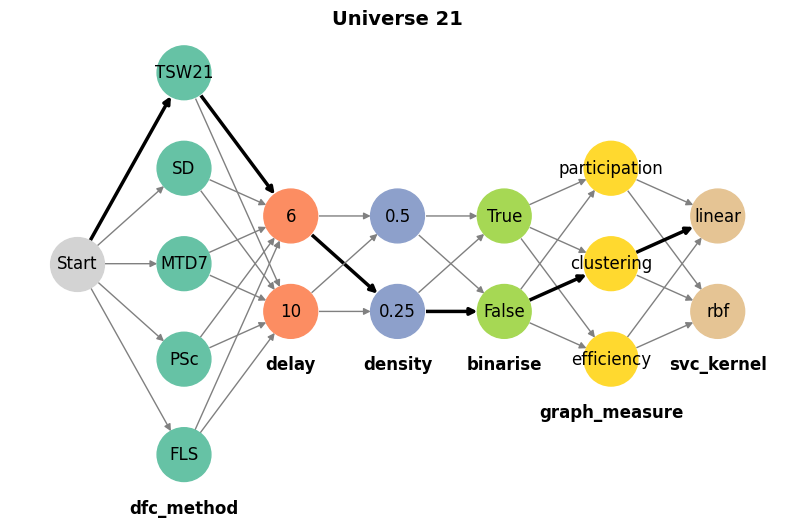

In [4]:
mverse.summary(universe=range(1,5));
mverse.visualize(universe=21, figsize=(10, 6));

Plot the specififcation curve. This can be done in two ways:

1) From .pkl results files of each universe saved in the main analysis template (see above). The ```measure``` argument has to be the name of the outcome variable.
2) From a single .csv file, with the results being an additional column

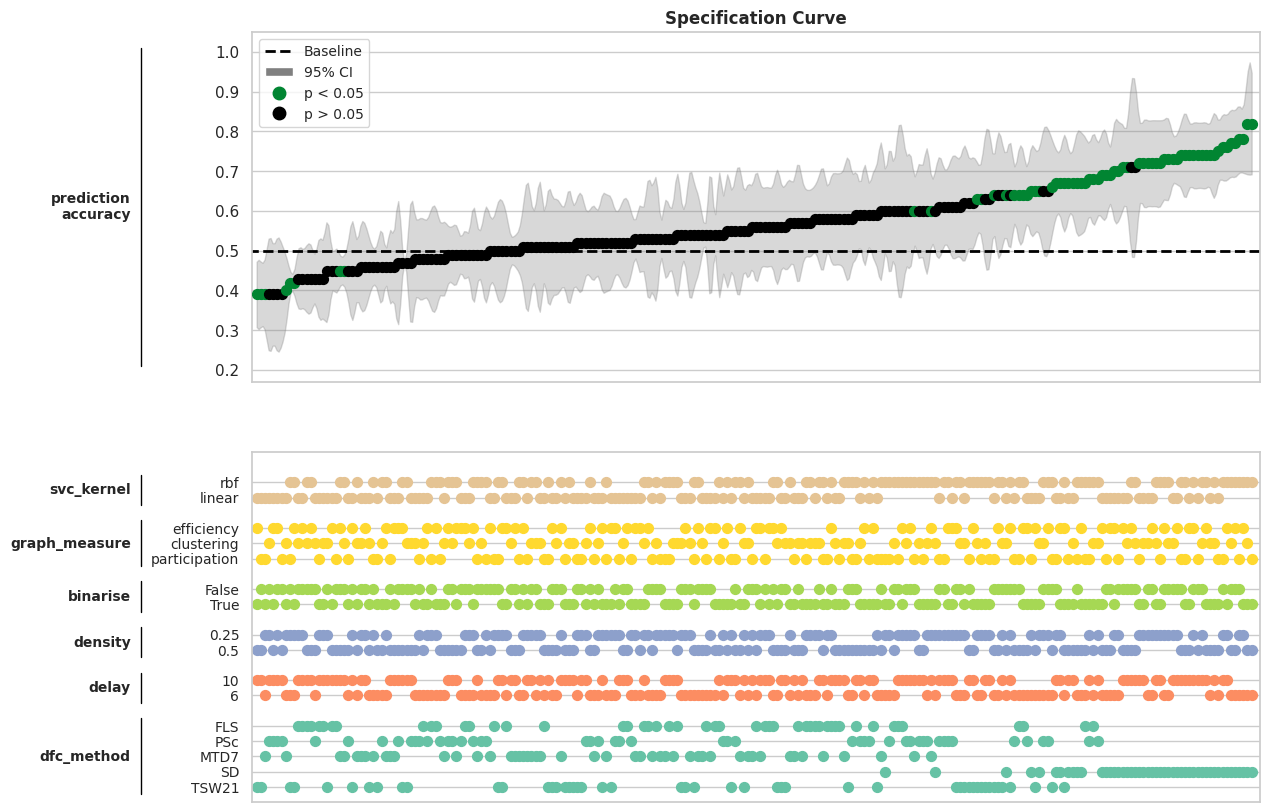

In [5]:
mverse.specification_curve(measure="prediction\naccuracy", title="Specification Curve",
                           baseline=0.5, p_value=0.05, ci=95, smooth_ci=True, \
                           cmap="Set2", figsize=(13,10), fontsize=10, height_ratio=[1,1]);